In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from utils.plotting import plot_trajectory
from utils.processing import (
    normalize_angles_2pi,
    open_file,
    cut_jumps,
    save_preprocessed_data,
    open_preprocessed_data )

In [2]:
DIR = 'preprocessed_dataset'
dfs_names = ['tr11', 'tr12', 'tr2','tr3','tr4','tr5','tr6','tr7', 'tr91','tr92']

# 1. Load datasets
dfs_dict = {}  # <------- now we use this dict 
for n in dfs_names:
    fname = os.path.join(DIR, f'{n}.pkl')
    subtraj_list = open_preprocessed_data(fname)
    dfs_dict[n] = subtraj_list

### Sort trajectories samples to near-wall / near-middle area

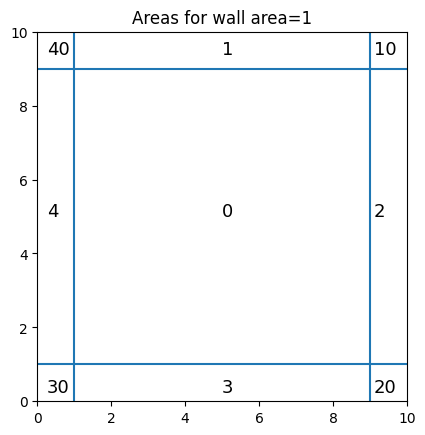

In [3]:
# demarkation of areas, made by hands :)
wall_percent = 1 # == 10%
square_len = 10

plt.axvline(wall_percent)
plt.axvline(square_len - wall_percent)
plt.axhline(wall_percent)
plt.axhline(square_len - wall_percent)

plt.text(wall_percent/4, wall_percent/4, '30', fontsize=13)
plt.text(square_len/2, wall_percent/4, '3', fontsize=13)
plt.text(square_len-0.9, wall_percent/4, '20', fontsize=13)

plt.text(wall_percent/4, square_len/2, '4', fontsize=13)
plt.text(square_len/2, square_len/2, '0', fontsize=13)
plt.text(square_len-0.9, square_len/2, '2', fontsize=13)

plt.text(wall_percent/4, square_len-0.6, '40', fontsize=13)
plt.text(square_len/2, square_len-0.6, '1', fontsize=13)
plt.text(square_len-0.9, square_len-0.6, '10', fontsize=13)

plt.xlim([0, square_len])
plt.ylim([0, square_len])
plt.title(f'Areas for wall area={wall_percent}')
plt.gca().set_aspect('equal')
plt.show()

In [4]:
borders = {}

for k, df_list in dfs_dict.items():
    merged_df = pd.concat(df_list)
    borders[k] = {
        'xmin': merged_df['x'].min(),
        'xmax': merged_df['x'].max(),
        'ymin': merged_df['y'].min(),
        'ymax': merged_df['y'].max(),
    }   

In [5]:
def sort_walls_area(tr, border_tr, wall_percent=0.1): 
    ylen = border_tr['ymax'] - border_tr['ymin'] 
    xlen = border_tr['xmax'] - border_tr['xmin'] 
    xl = border_tr['xmin'] + xlen * wall_percent
    xr = border_tr['xmax'] - xlen * wall_percent
    yd = border_tr['ymin'] + ylen * wall_percent
    yu = border_tr['ymax'] - ylen * wall_percent

    tr['near_wall'] = 0.
    for i in range(len(tr)):     
        if tr['x'].iloc[i] < xl:
            if tr['y'].iloc[i] > yu:
                tr['near_wall'].iloc[i] = 40
            elif tr['y'].iloc[i] < yd:
                tr['near_wall'].iloc[i] = 30
            else:
                tr['near_wall'].iloc[i] = 4
        elif tr['x'].iloc[i] > xr:
            if tr['y'].iloc[i] > yu:
                tr['near_wall'].iloc[i] = 10
            elif tr['y'].iloc[i] < yd:
                tr['near_wall'].iloc[i] = 20
            else:
                tr['near_wall'].iloc[i] = 2
        elif tr['y'].iloc[i] > yu:
            tr['near_wall'].iloc[i] = 1
        elif tr['y'].iloc[i] < yd:
            tr['near_wall'].iloc[i] = 3
    return tr

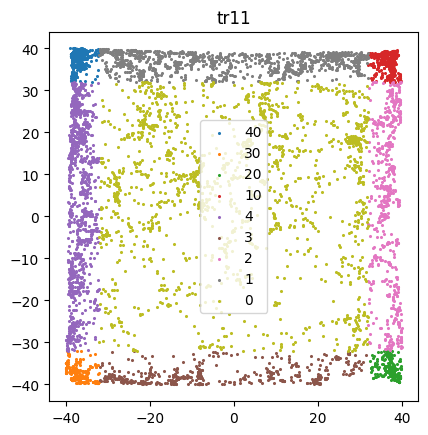

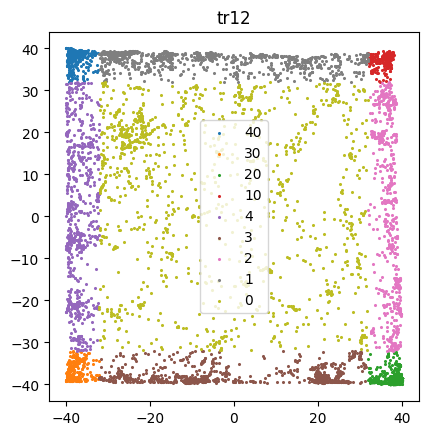

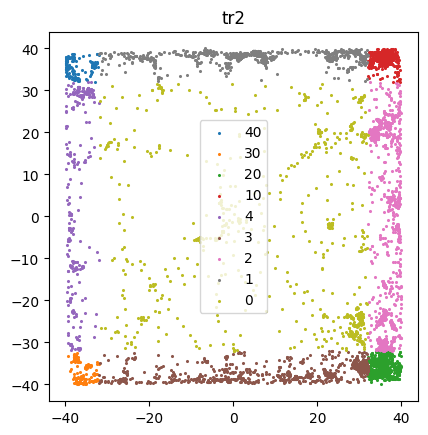

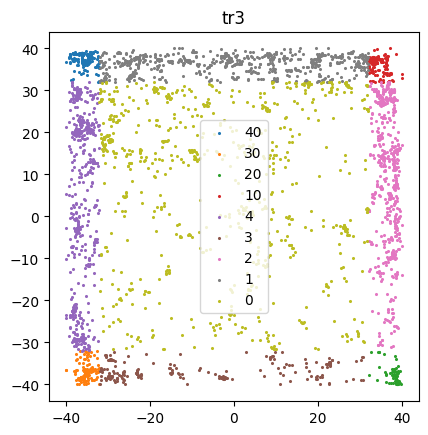

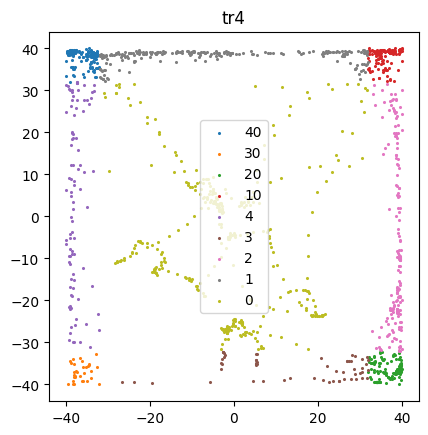

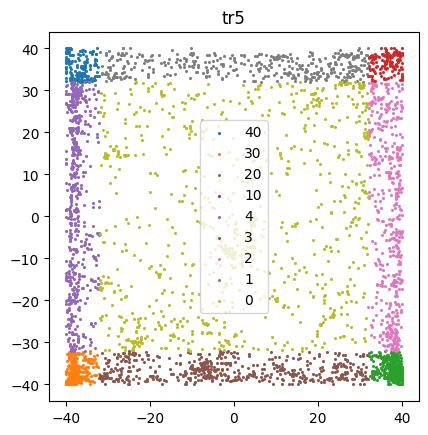

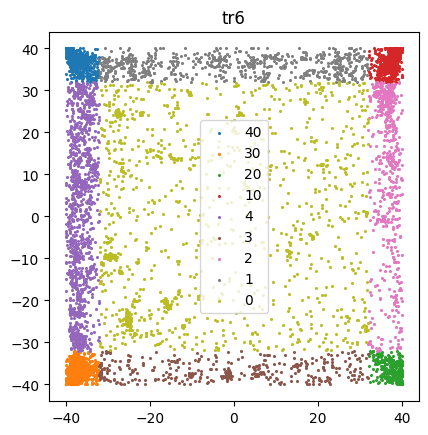

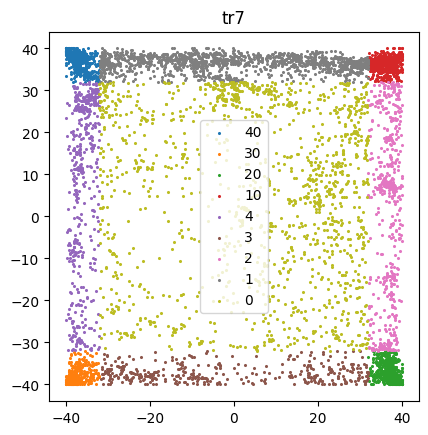

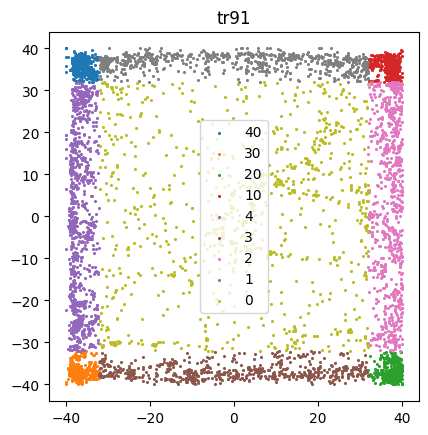

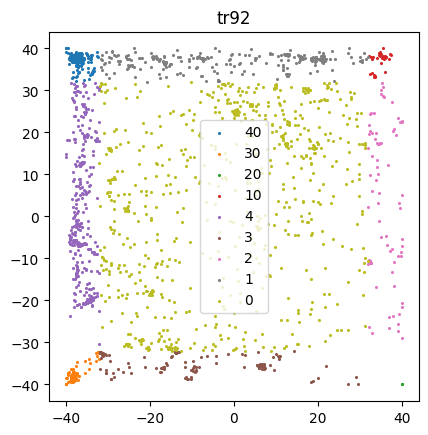

In [7]:
def plot_wall_sorted_samples(df, plot_title):
    all_areas = [40, 30, 20, 10, 4, 3, 2, 1, 0]
    for a in all_areas:
        x = df.loc[df['near_wall'] == a]['x']
        y = df.loc[df['near_wall'] == a]['y']
        plt.scatter(x, y, s=1.5, label=str(a))
    plt.gca().set_aspect('equal')
    plt.title(plot_title)
    plt.legend(loc='center')
    plt.show()

dfs_with_walls = {}

for k, df_list in dfs_dict.items():
    df = pd.concat(df_list)
    dfs_with_walls[k] = sort_walls_area(df, borders[k])
    plot_wall_sorted_samples(dfs_with_walls[k], k)
    # break

### Check the step length in different areas

#### Calculate mean len of steps

In [9]:
step_stat = []
for k, df in dfs_with_walls.items():
    co = df.loc[df['near_wall']>=10]['step_length'].mean()
    w = df.loc[(df['near_wall']>=1) & (df['near_wall']<=4)]['step_length'].mean()
    ce = df.loc[(df['near_wall']==0) & (df['near_wall']==0)]['step_length'].mean()
    step_stat.append([co, ce, w])

for i, df_idx in enumerate(step_stat):
    print(f'For data {dfs_names[i]}: cornMean={round(df_idx[0], 3)}, wallMean={round(df_idx[1], 3)}, centMean={round(df_idx[2], 3)}')

For data tr11: cornMean=0.352, wallMean=1.433, centMean=1.075
For data tr12: cornMean=0.396, wallMean=2.057, centMean=1.199
For data tr2: cornMean=0.333, wallMean=1.324, centMean=0.828
For data tr3: cornMean=1.434, wallMean=2.644, centMean=2.054
For data tr4: cornMean=1.839, wallMean=1.677, centMean=2.838
For data tr5: cornMean=2.516, wallMean=3.789, centMean=4.084
For data tr6: cornMean=1.773, wallMean=2.745, centMean=2.461
For data tr7: cornMean=1.594, wallMean=3.135, centMean=2.185
For data tr91: cornMean=1.106, wallMean=3.369, centMean=2.057
For data tr92: cornMean=1.088, wallMean=3.984, centMean=0.528


In [20]:
df = dfs_with_step_lens['tr1']
print(df.loc[df['near_wall']>=10]['step_length'].mean())
print(df.loc[df['near_wall']>=10]['step_length'].median())

0.8451297490775153
0.290688837074972


####  Проверим зависимость изменения угла от угла (в разных зонах)

In [21]:
DfsStep13, DfsStep24 = {}, {}
for k, df in dfs_with_step_lens.items():
    DfsStep13[k] = df.loc[(df['near_wall']==1) | (df['near_wall']==3)]
    DfsStep13[k] = DfsStep13[k].reset_index()
    DfsStep13[k] = DfsStep13[k].drop(['index'], axis=1) 

    DfsStep24[k] = df.loc[(df['near_wall']==2) | (df['near_wall']==4)]
    DfsStep24[k] = DfsStep24[k].reset_index()
    DfsStep24[k] = DfsStep24[k].drop(['index'], axis=1)

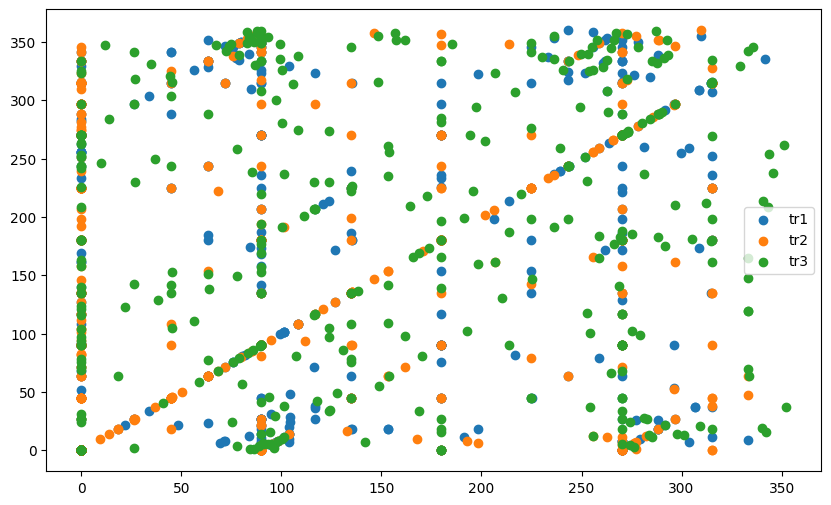

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
for i in DfsStep13:
    plt.scatter(DfsStep13[i]['angles'], DfsStep13[i]['delta_angle'], label=i)
    if i =='tr3':  # TMP
        break
plt.legend()
plt.show()

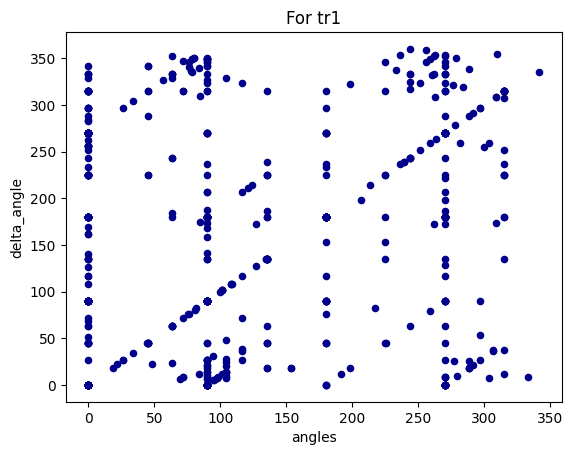

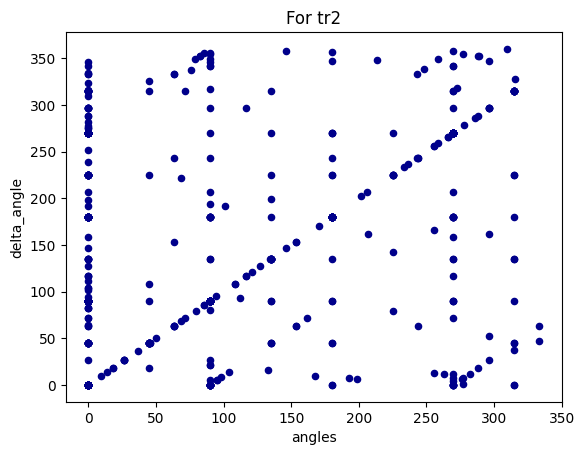

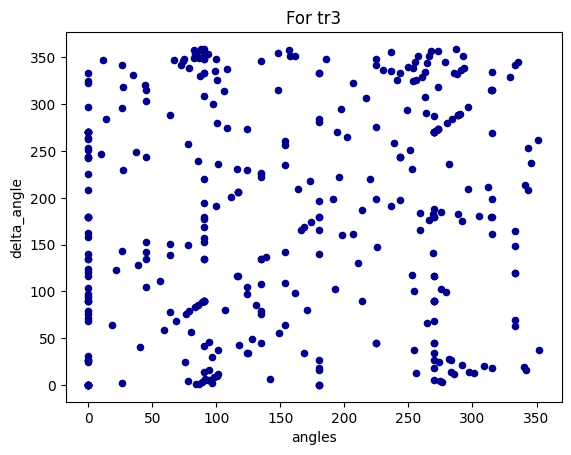

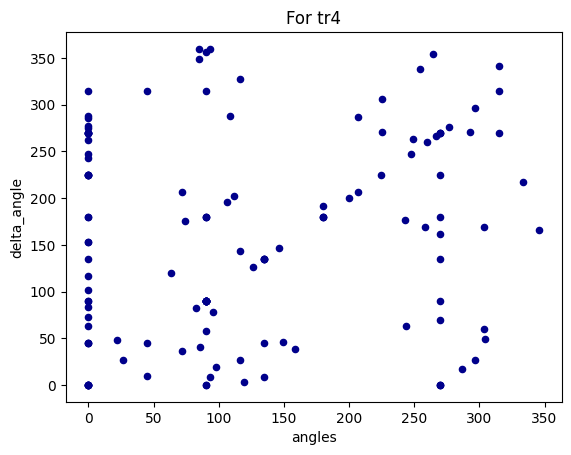

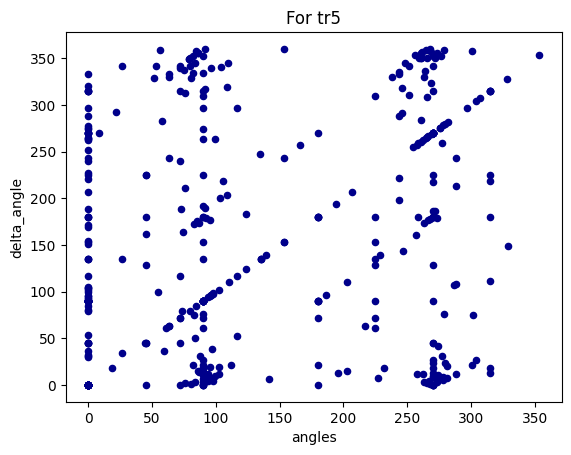

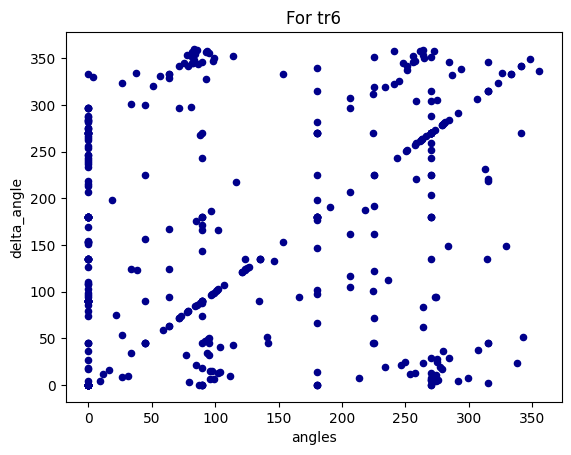

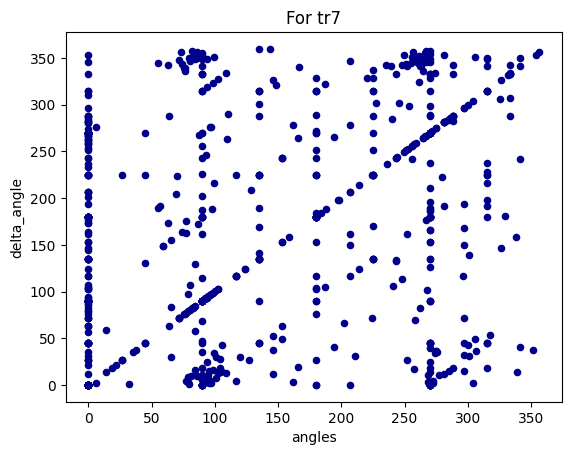

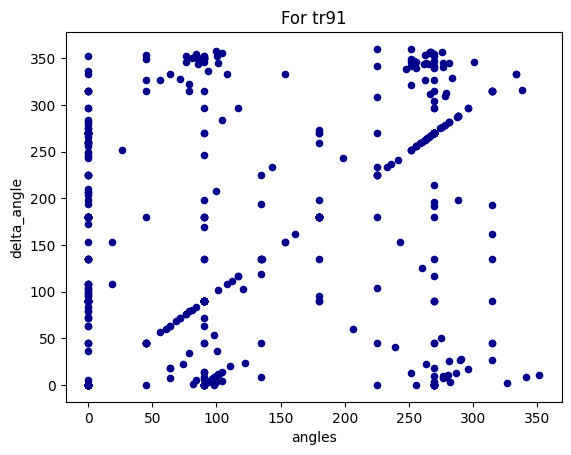

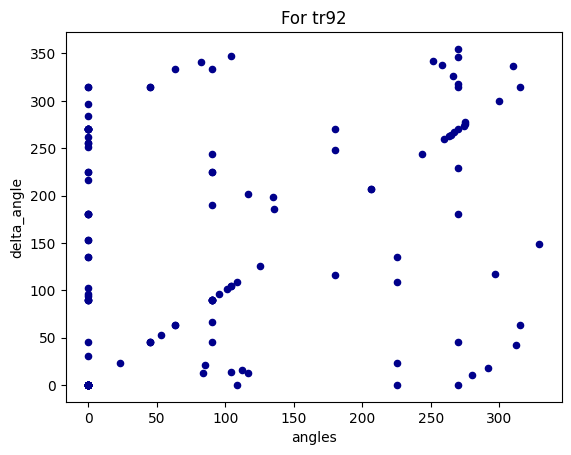

In [23]:
for i in DfsStep13:
    DfsStep13[i].plot.scatter(x='angles',y='delta_angle', c='DarkBlue')
    plt.title(f'For {i}')
    plt.show()

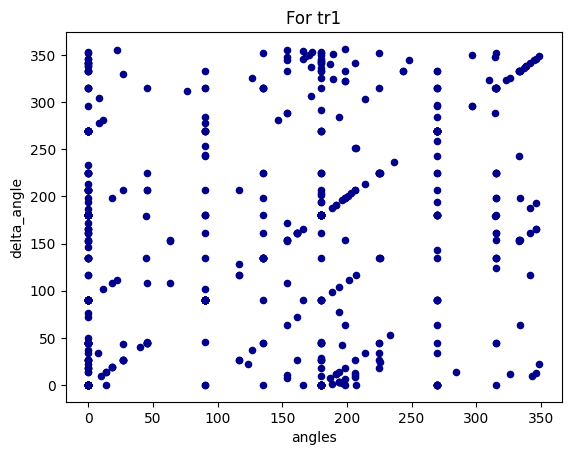

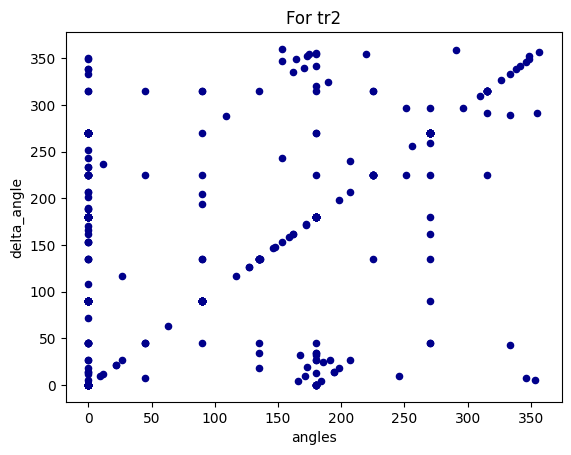

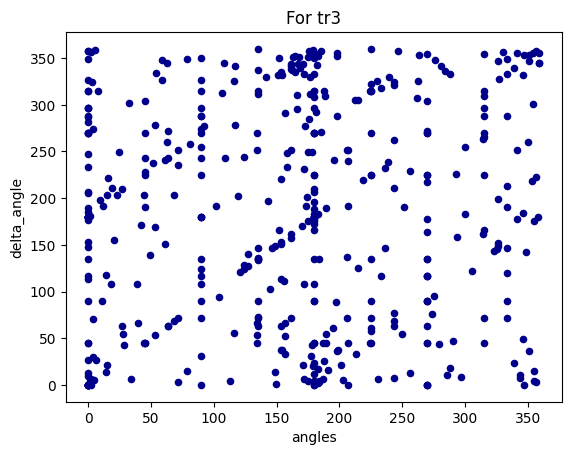

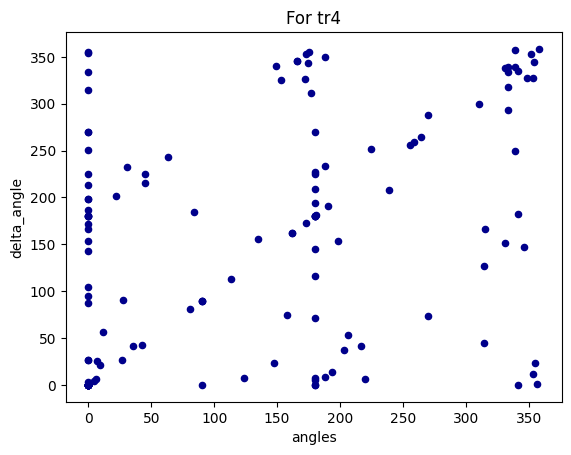

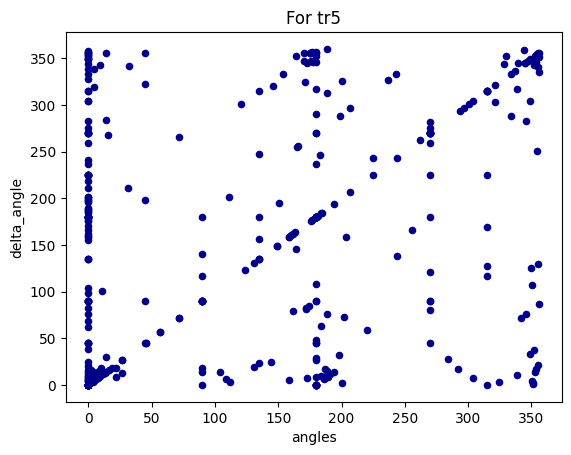

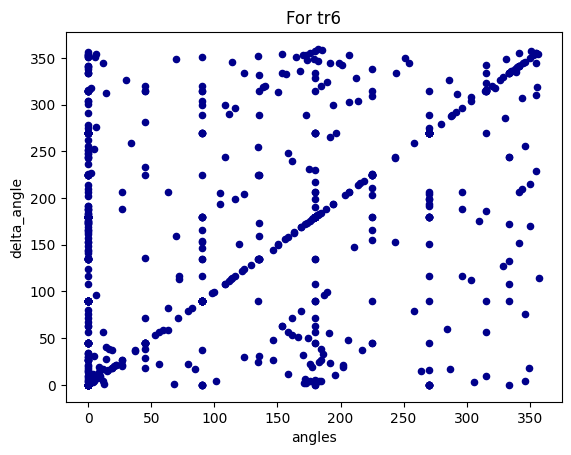

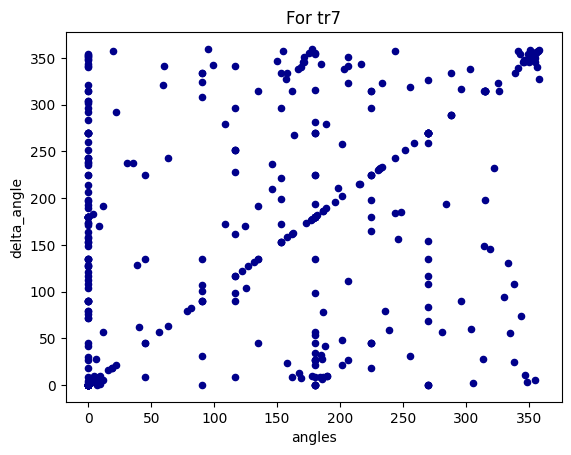

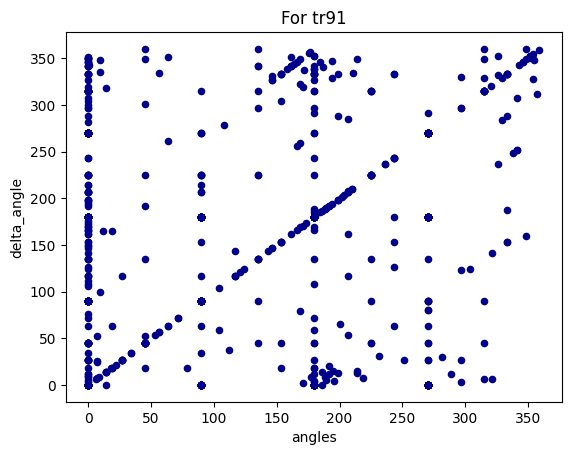

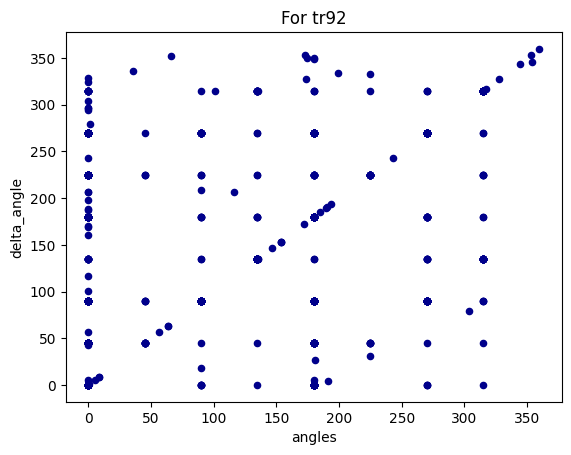

In [24]:
for i in DfsStep24:
    DfsStep24[i].plot.scatter(x='angles',y='delta_angle', c='DarkBlue')
    plt.title(f'For {i}')
    plt.show()

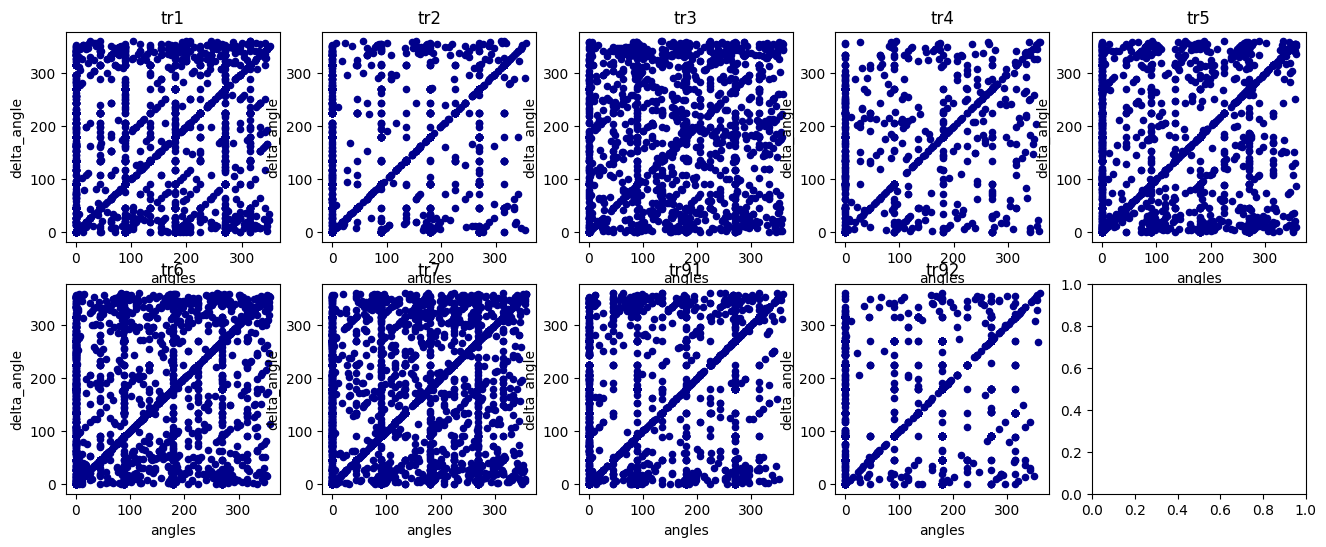

In [25]:
# In 9 all areas
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
j, i = 0, 0
for k in dfs_with_step_lens:
    dfs_with_step_lens[k].plot.scatter(x='angles',y='delta_angle', c='DarkBlue', ax=axes[j, i])
    axes[j, i].set_title(k)
    i += 1
    if i == 5:
        j = 1
        i = 0
plt.show()

### Look how angles / delta angles are for 1,2,3,4 walls

In [26]:
dfs_walls = {}
walls = [1, 2, 3, 4]

for w in walls:
    df_steps_for_wall = {}

    for i in dfs_with_step_lens:
        df = dfs_with_step_lens[i]
        df_steps_for_wall[i] = df.loc[df['near_wall']==w]
        df_steps_for_wall[i] = df_steps_for_wall[i].reset_index()
        df_steps_for_wall[i] = df_steps_for_wall[i].drop(['index'], axis=1)

    dfs_walls[w] = df_steps_for_wall

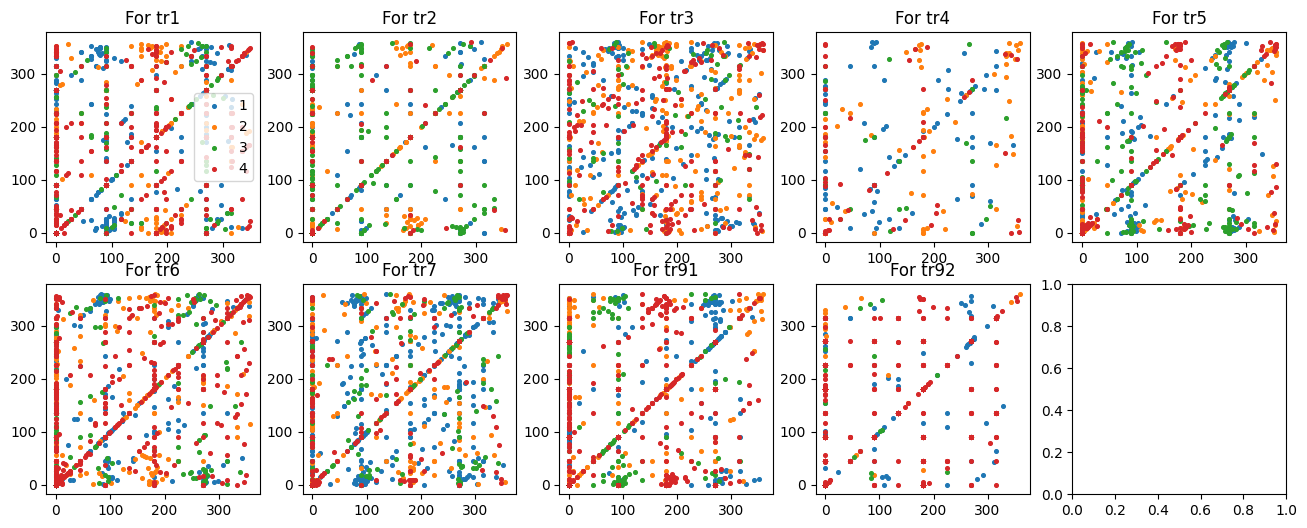

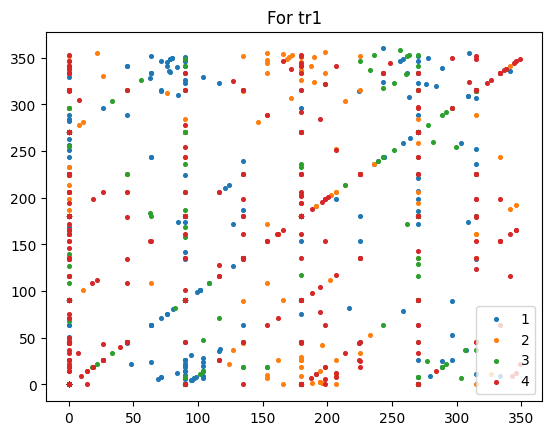

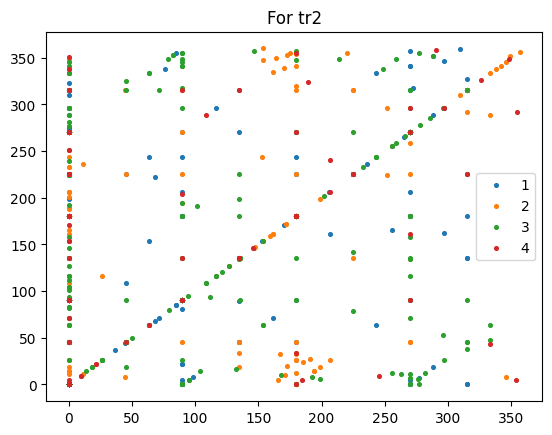

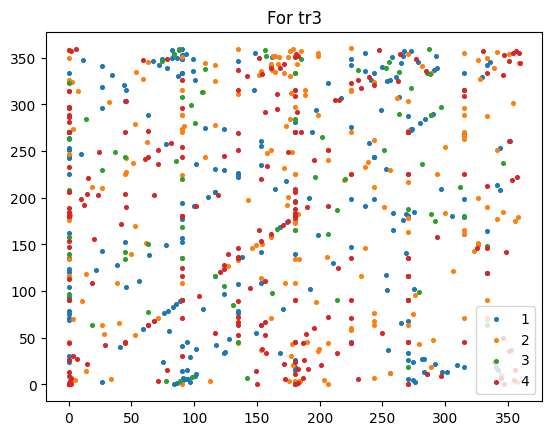

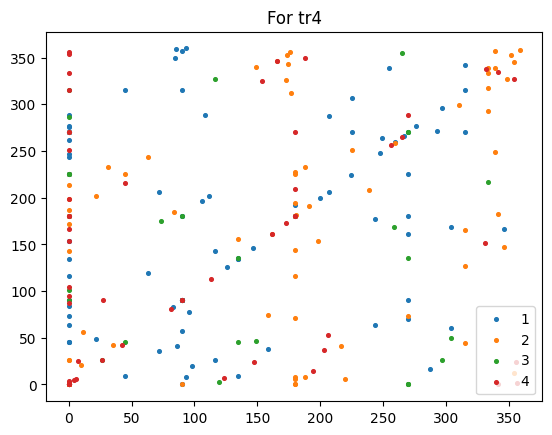

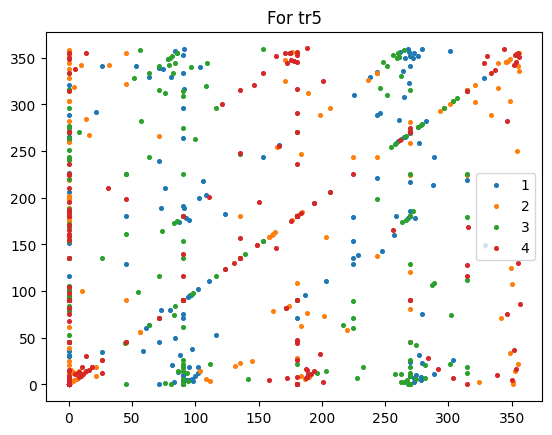

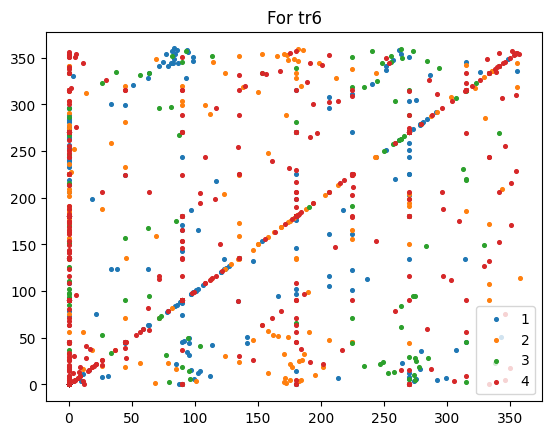

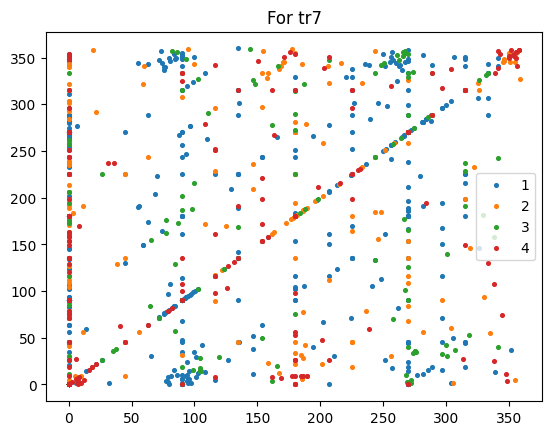

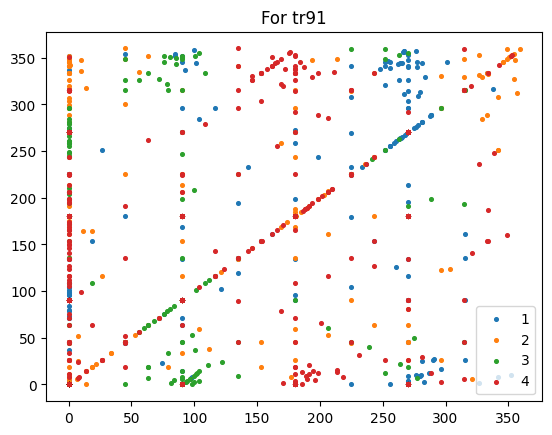

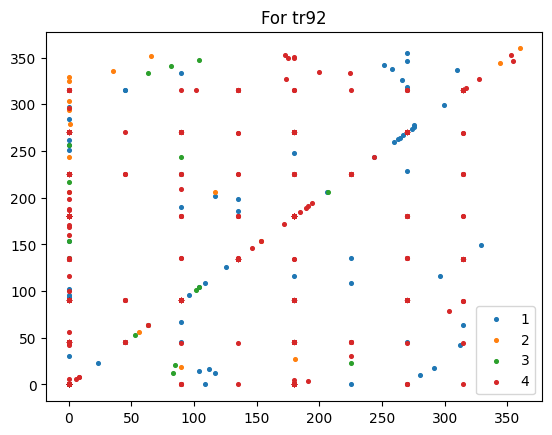

In [27]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
j, i = 0, 0
for k, df in dfs_with_step_lens.items():
    for w in walls:
        dfw = dfs_walls[w][k]
        axes[j, i].scatter(dfw['angles'], dfw['delta_angle'], s=7, label=w)
    axes[j, i].set_title(f'For {k}')
    i += 1
    if i == 5:
        j = 1
        i = 0
axes[0, 0].legend()
plt.show()

## OR one-by-one
for k, df in dfs_with_step_lens.items():
    for w in walls:
        dfw = dfs_walls[w][k]
        plt.scatter(dfw['angles'], dfw['delta_angle'], s=7, label=w)
    plt.title(f'For {k}')
    plt.legend()
    plt.show()
    # break

### Look how angles / delta angles are for 10,20,30,40 walls

In [28]:
dfs_walls = {}
walls = [10, 20, 30, 40]

for w in walls:
    df_steps_for_wall = {}

    for i in dfs_with_step_lens:
        df = dfs_with_step_lens[i]
        df_steps_for_wall[i] = df.loc[df['near_wall']==w]
        df_steps_for_wall[i] = df_steps_for_wall[i].reset_index()
        df_steps_for_wall[i] = df_steps_for_wall[i].drop(['index'], axis=1)

    dfs_walls[w] = df_steps_for_wall

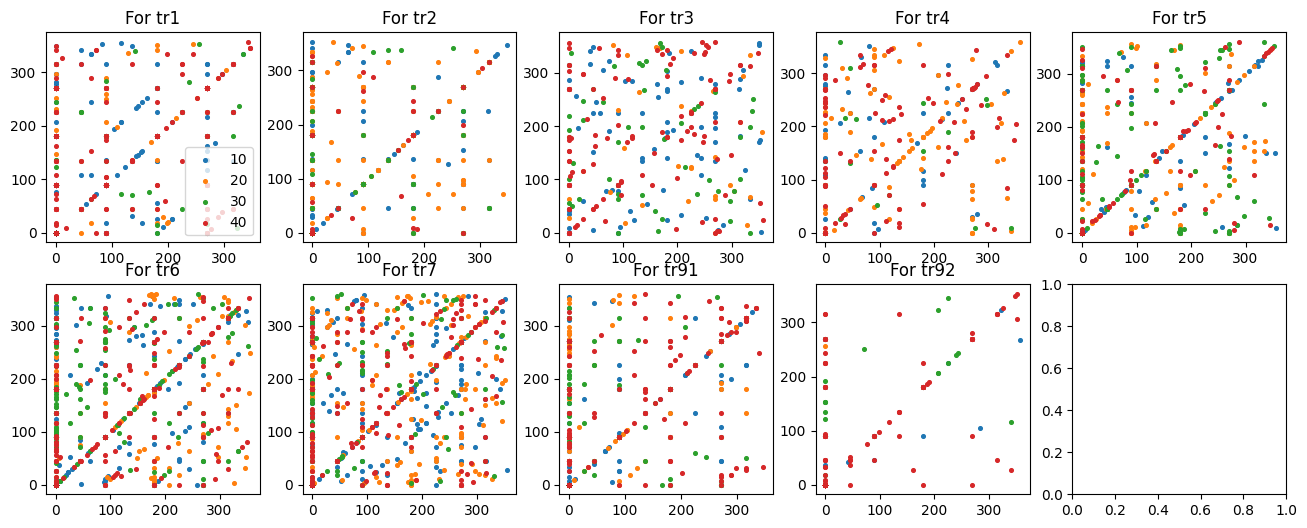

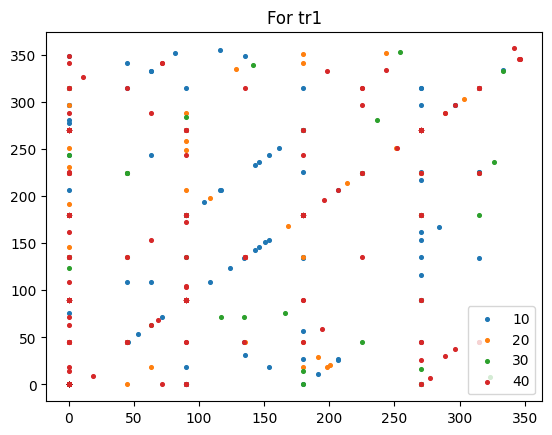

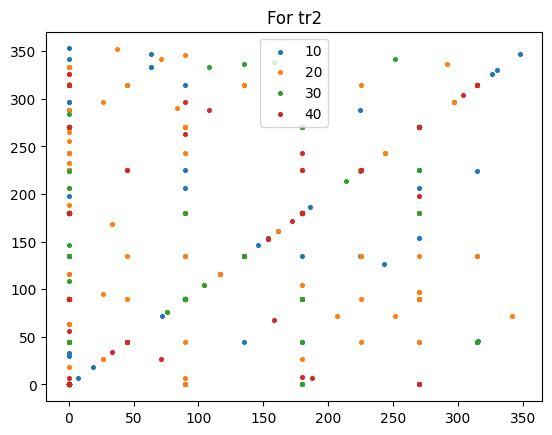

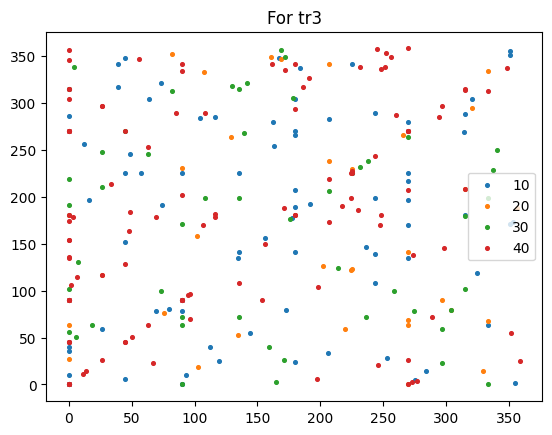

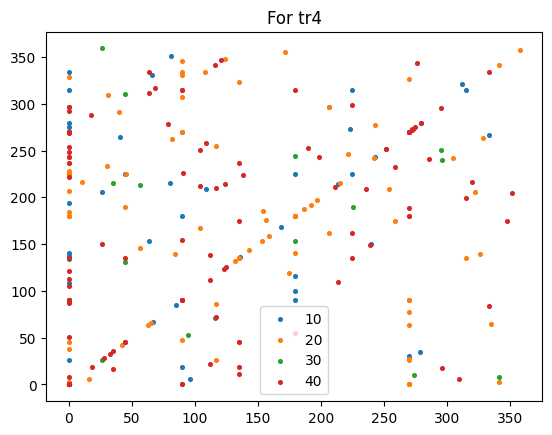

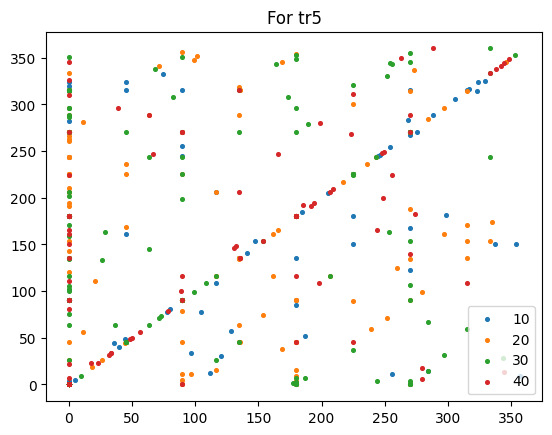

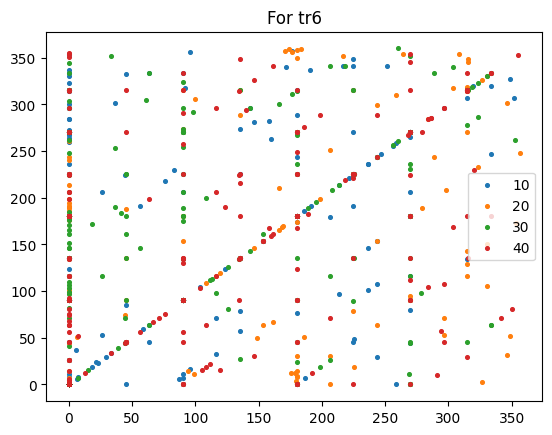

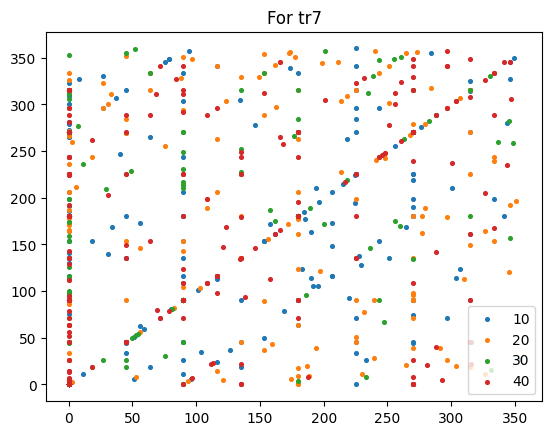

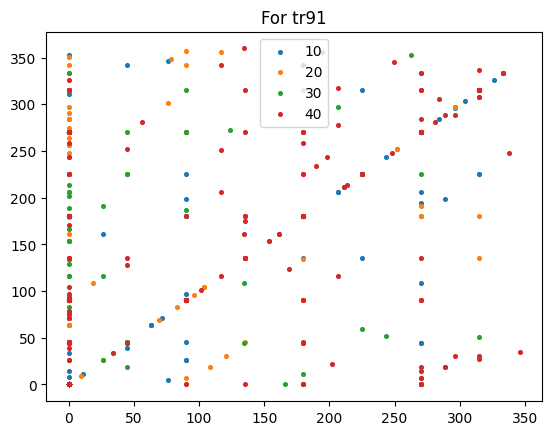

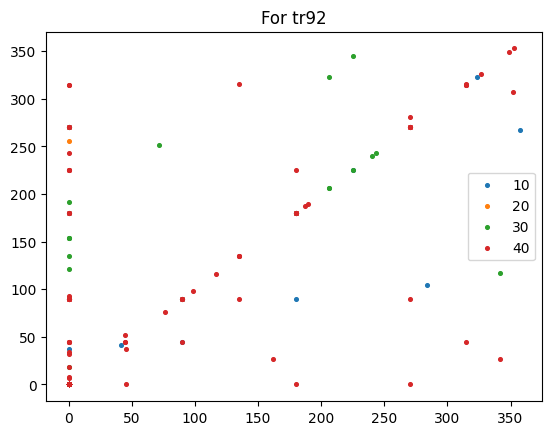

In [29]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
j, i = 0, 0
for k, df in dfs_with_step_lens.items():
    for w in walls:
        dfw = dfs_walls[w][k]
        axes[j, i].scatter(dfw['angles'], dfw['delta_angle'], s=7, label=w)
    axes[j, i].set_title(f'For {k}')
    i += 1
    if i == 5:
        j = 1
        i = 0
axes[0, 0].legend()
plt.show()

## OR one-by-one
for k, df in dfs_with_step_lens.items():
    for w in walls:
        dfw = dfs_walls[w][k]
        plt.scatter(dfw['angles'], dfw['delta_angle'], s=7, label=w)
    plt.title(f'For {k}')
    plt.legend()
    plt.show()
    # break

### посчитаем сколько значений в 1,3 и 2,4 зонах, в которых угол в окрестностях таргетных углов (параллельных стене) и остальных углов (не параллельных стене) - НЕ нужно для построения распределения

In [30]:
#в скольких точек угол мыши параллелен стене +- 25 градусов
# for 1, 3: [90 +- 25], [270 +- 25]; [65, 115], [245, 295]
# for 2, 4: [0 +- 25], [180 +- 25] ; [335 , 25], [155, 205]

for k, df in DfsStep13.items():
    mask = ((df['angles']>=65) & (df['angles']<=115)) \
                               | ((df['angles']>=245) & (df['angles']<=295))
    parallel_df = df.loc[mask]
    not_parallel_df = df[~mask]

    print(f'For {k}: Total len={len(df)}, parallel={len(parallel_df)}, not_parallel={len(not_parallel_df)}')

print('\n')

for k, df in DfsStep24.items():
    mask = ((df['angles']>=335) | (df['angles']<=25)) \
                               | ((df['angles']>=155) & (df['angles']<=205))
    parallel_df = df.loc[mask]
    not_parallel_df = df[~mask]

    print(f'For {k}: Total len={len(df)}, parallel={len(parallel_df)}, not_parallel={len(not_parallel_df)}')
    # break

parallel_df

For tr1: Total len=777, parallel=280, not_parallel=497
For tr2: Total len=916, parallel=199, not_parallel=717
For tr3: Total len=371, parallel=159, not_parallel=212
For tr4: Total len=137, parallel=55, not_parallel=82
For tr5: Total len=425, parallel=221, not_parallel=204
For tr6: Total len=463, parallel=171, not_parallel=292
For tr7: Total len=885, parallel=316, not_parallel=569
For tr91: Total len=633, parallel=248, not_parallel=385
For tr92: Total len=156, parallel=46, not_parallel=110


For tr1: Total len=796, parallel=535, not_parallel=261
For tr2: Total len=734, parallel=598, not_parallel=136
For tr3: Total len=472, parallel=229, not_parallel=243
For tr4: Total len=141, parallel=101, not_parallel=40
For tr5: Total len=440, parallel=334, not_parallel=106
For tr6: Total len=983, parallel=684, not_parallel=299
For tr7: Total len=451, parallel=301, not_parallel=150
For tr91: Total len=1487, parallel=973, not_parallel=514
For tr92: Total len=2215, parallel=1755, not_parallel=460


time       x       y  angles  delta_angle  near_wall  step_length
0        1.001  29.919  -9.381     0.0      0.00000        2.0     0.000000
1        1.502  30.934   7.353     0.0      0.00000        2.0    16.764754
3       23.991  35.244  26.877     0.0    296.51983        2.0     2.268267
4       37.504 -42.343  14.453     0.0    180.00000        4.0    27.638158
5       38.005 -44.372  -5.325   180.0    180.00000        4.0    19.881804
...        ...     ...     ...     ...          ...        ...          ...
2210  1676.542 -41.076 -24.341     0.0      0.00000        4.0     0.253000
2211  1677.042 -41.076 -24.341   180.0    180.00000        4.0     0.000000
2212  1677.543 -41.076 -24.341   180.0      0.00000        4.0     0.000000
2213  1678.043 -41.076 -24.088     0.0    180.00000        4.0     0.253000
2214  1678.544 -41.076 -24.341     0.0      0.00000        4.0     0.253000

[1755 rows x 7 columns]

### Соберем нужные условия и сделаем общий scatter plot (все мыши в 1й таблице)

Для 13 паралл, 13 рег, 24 пар, 24 рег. 13 парал = значит точки, находящиеся в зонах 1 и 3, в которых значения угла мыши +- параллельны стене, и тд. НУЖНО для построения распределения (нужны dfPar24 и тд)

In [31]:
# del DfsStep24['tr92']  # TODO: why?

tr1 280 497
tr2 199 600
tr3 159 212
tr4 55 82
tr5 221 204
tr6 171 292
tr7 316 569
tr91 248 385
tr92 46 110


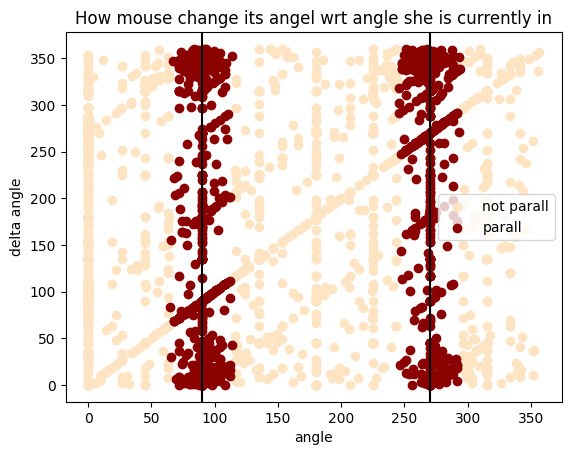

In [32]:
par13 = []
reg13 = []
l = 600 # 233
for k, df in DfsStep13.items():
    mask = ((df['angles']>=65) & (df['angles']<=115)) \
                               | ((df['angles']>=245) & (df['angles']<=295))
    parallel_df = df.loc[mask]
    not_parallel_df = df[~mask]

    print(k, len(parallel_df[:l]), len(not_parallel_df[:l]))
    par13.append(parallel_df[:l]) 
    reg13.append(not_parallel_df[:l])
    
dfPar13 = pd.concat(par13)
dfReg13 = pd.concat(reg13)

plt.scatter(dfReg13['angles'], dfReg13['delta_angle'], color='bisque', label='not parall')
plt.scatter(dfPar13['angles'], dfPar13['delta_angle'], color='darkred', label='parall')
plt.axvline(90, c='black')
plt.axvline(270, c='black')
plt.legend()
plt.title('How mouse change its angel wrt angle she is currently in')
plt.xlabel('angle')
plt.ylabel('delta angle')
plt.show()

tr1 535 261
tr2 598 136
tr3 229 243
tr4 101 40
tr5 334 106
tr6 600 299
tr7 301 150
tr91 600 514
tr92 600 460


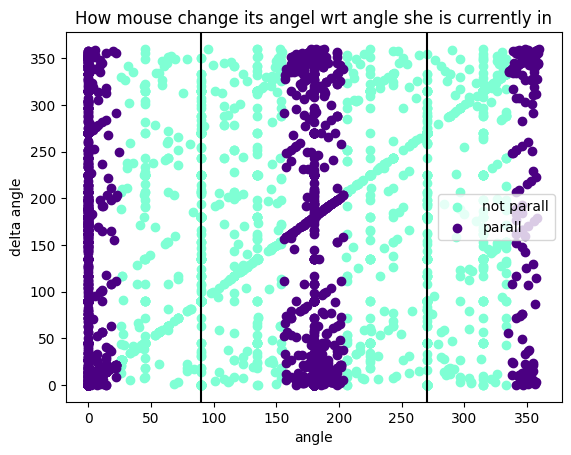

In [33]:
par24 = []
reg24 = []
l = 600 #233
for k, df in DfsStep24.items():
    mask = ((df['angles']>=335) | (df['angles']<=25)) \
                               | ((df['angles']>=155) & (df['angles']<=205))
    parallel_df = df.loc[mask]
    not_parallel_df = df[~mask]

    print(k, len(parallel_df[:l]), len(not_parallel_df[:l]))
    par24.append(parallel_df[:l]) 
    reg24.append(not_parallel_df[:l])
    
dfPar24 = pd.concat(par24)
dfReg24 = pd.concat(reg24)

plt.scatter(dfReg24['angles'], dfReg24['delta_angle'], color='aquamarine', label='not parall')
plt.scatter(dfPar24['angles'], dfPar24['delta_angle'], color='indigo', label='parall')
plt.axvline(90, c='black')
plt.axvline(270, c='black')
plt.legend()
plt.title('How mouse change its angel wrt angle she is currently in')
plt.xlabel('angle')
plt.ylabel('delta angle')
plt.show()

### мы тут смотрим общие (для всех мышей) распределения изменения углов в зонах рядом со стенами (в зонах 1 и 3; 2 и 4) отдельно для углов +- параллельных стене и нет. сравниваем распределения

Bin size is 5.999785086762037 (degrees)


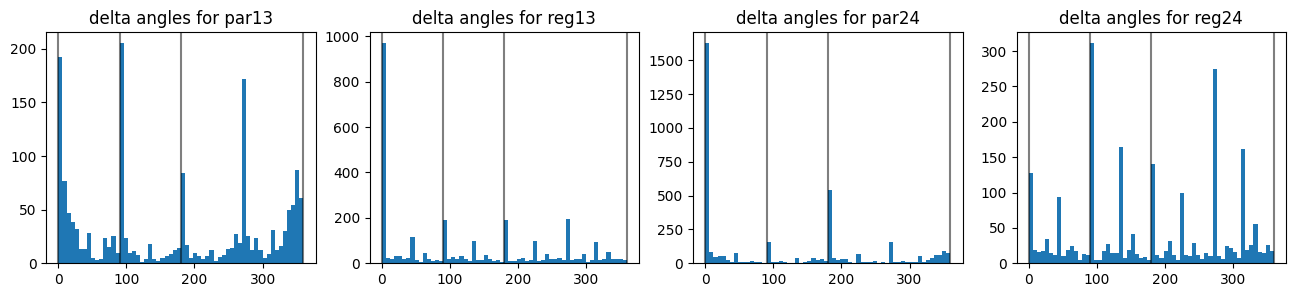

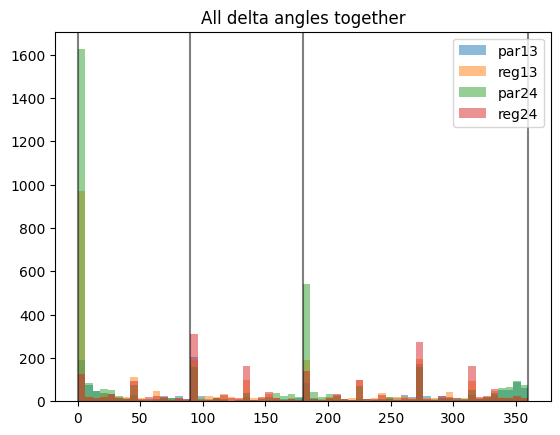

In [34]:
bins = 60
wall_hist = {}
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
names = ['par13', 'reg13', 'par24', 'reg24']
for i, dat in enumerate([dfPar13, dfReg13, dfPar24, dfReg24]):
    freqs, binEdges, _ = axes[i].hist(dat['delta_angle'], bins=bins)
    if i ==0:
        print(f'Bin size is {binEdges[1] - binEdges[0]} (degrees)')
    for ang in [0, 90, 180, 360]:
        axes[i].axvline(ang, c='black', alpha=0.5)
    axes[i].set_title(f'delta angles for {names[i]}')

    bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
    wall_hist[names[i]] = [bin_mid, freqs]
plt.show()

# all together
for i, dat in enumerate([dfPar13, dfReg13, dfPar24, dfReg24]):
    plt.hist(dat['delta_angle'], label=names[i], alpha=0.5, bins=bins)
for ang in [0, 90, 180, 360]:
    plt.axvline(ang, c='black', alpha=0.5)
plt.title('All delta angles together')
plt.legend()
plt.show()

In [35]:
# Save distributions
import pickle
with open(f'angWallsDistr_nbins_{bins}.pkl', 'wb') as fp:
    pickle.dump(wall_hist, fp)

### all_hist словарь с гистограммами распределений изменения углов для каждой зоны для каждой мыши

Bin size is 5.999267130106642 (degrees)


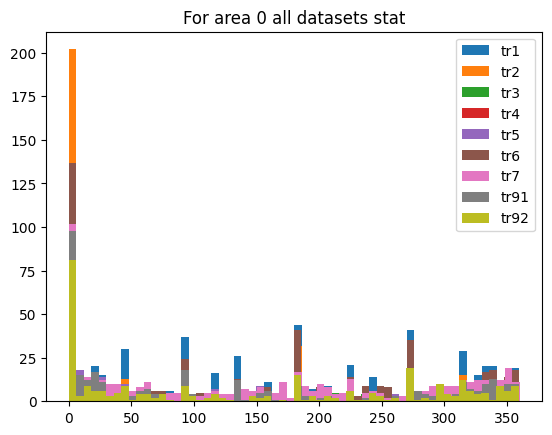

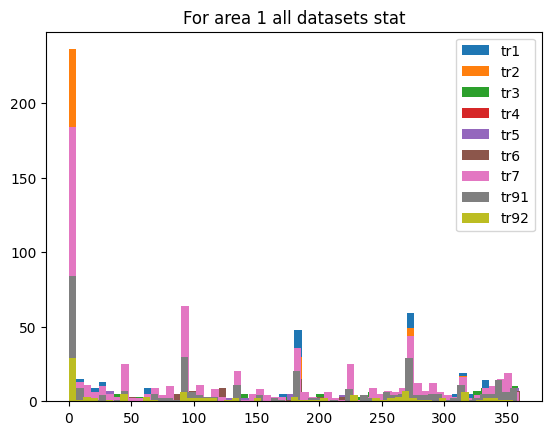

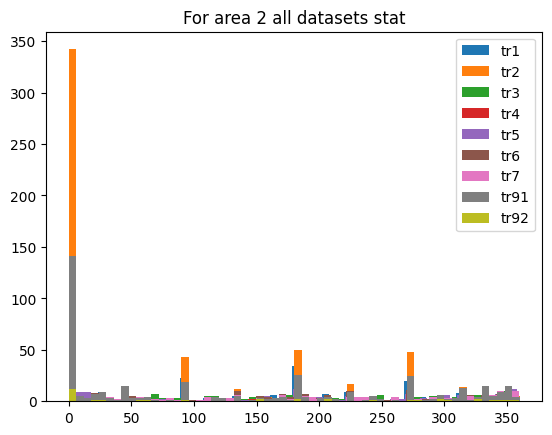

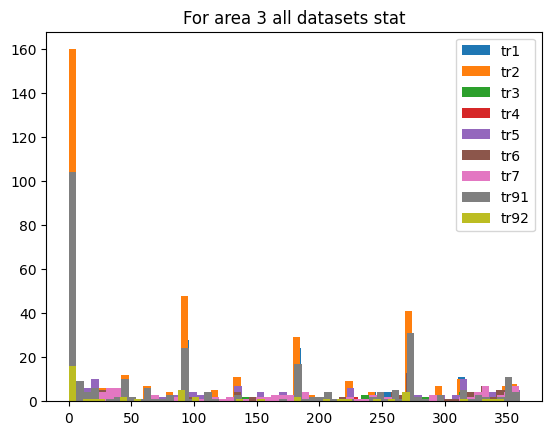

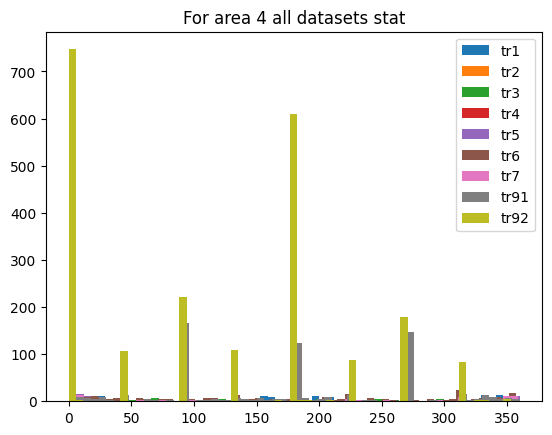

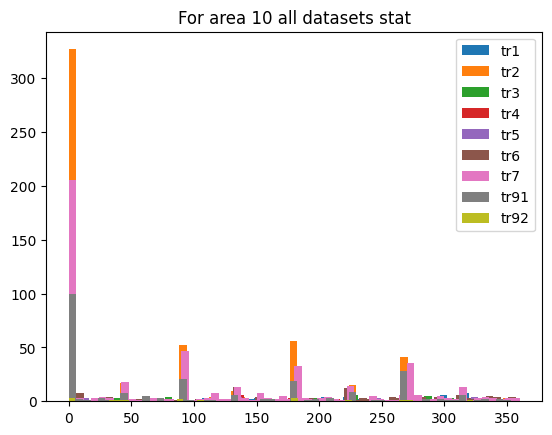

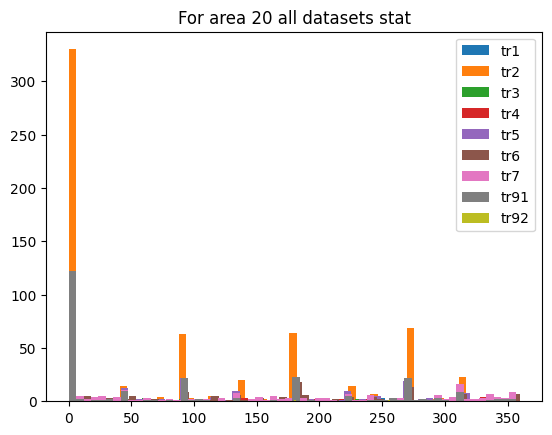

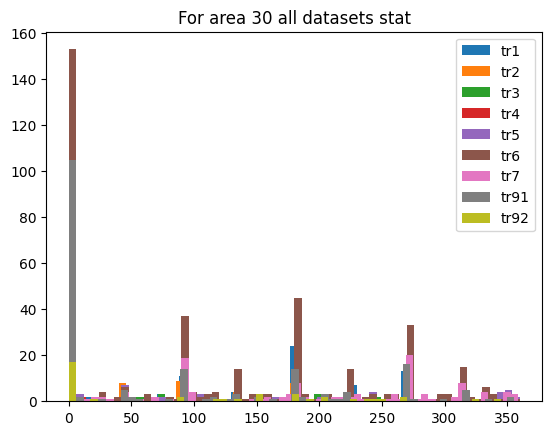

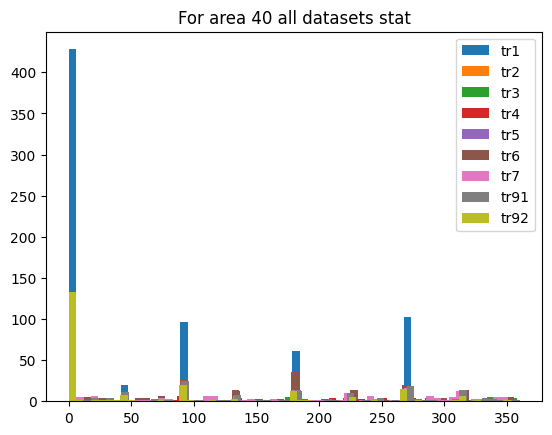

In [36]:
bins = 60
all_hist = {}

for area in [0, 1, 2, 3, 4, 10, 20, 30, 40]:
    all_hist[area] = {}

    for k, df in dfs_with_step_lens.items():
        df_area = df.loc[df['near_wall'] == area]
        freqs, binEdges, _ = plt.hist(df_area['delta_angle'], bins=bins, label=k)
        if k == 'tr1' and area==0:
            print(f'Bin size is {binEdges[1] - binEdges[0]} (degrees)')
        bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])

        all_hist[area][k] = [bin_mid, freqs]
    plt.title(f'For area {area} all datasets stat')
    plt.legend()
    plt.show()

### возьмем от каждой мыши (в каждой зоне) одинаковое количество точек. но от некоторых мышей выйдет чуть меньше точек, чем от большинства. создадим словари с полученными обрезанными таблицами dict0, dict1 и тд

In [52]:
for k, df in dfs_with_step_lens.items():
    for area in [0, 1, 2, 3, 4, 10, 20, 30, 40]:
        print(f'For {k} in {area} area: len={len(df.loc[df["near_wall"] == area])}')

For tr1 in 0 area: len=711
For tr1 in 1 area: len=537
For tr1 in 2 area: len=267
For tr1 in 3 area: len=240
For tr1 in 4 area: len=529
For tr1 in 10 area: len=204
For tr1 in 20 area: len=118
For tr1 in 30 area: len=118
For tr1 in 40 area: len=781
For tr2 in 0 area: len=439
For tr2 in 1 area: len=491
For tr2 in 2 area: len=619
For tr2 in 3 area: len=425
For tr2 in 4 area: len=115
For tr2 in 10 area: len=566
For tr2 in 20 area: len=648
For tr2 in 30 area: len=121
For tr2 in 40 area: len=63
For tr3 in 0 area: len=282
For tr3 in 1 area: len=282
For tr3 in 2 area: len=239
For tr3 in 3 area: len=89
For tr3 in 4 area: len=233
For tr3 in 10 area: len=90
For tr3 in 20 area: len=36
For tr3 in 30 area: len=51
For tr3 in 40 area: len=127
For tr4 in 0 area: len=154
For tr4 in 1 area: len=108
For tr4 in 2 area: len=88
For tr4 in 3 area: len=29
For tr4 in 4 area: len=53
For tr4 in 10 area: len=73
For tr4 in 20 area: len=112
For tr4 in 30 area: len=16
For tr4 in 40 area: len=100
For tr5 in 0 area: len

In [53]:
def cut_into_dict(dfs_dict, area, max_len):
    cutted_df_dict = {}
    for k, df in dfs_dict.items():
        # print(k + ' ' + str(area))  # tmp
        cutted_df = df.loc[df['near_wall'] == area]
        # print(len(cutted_df))  # tmp
        cutted_df = cutted_df.iloc[:max_len]
        # print(len(cutted_df))  # tmp
        cutted_df_dict[k] = cutted_df

    return cutted_df_dict

In [54]:
walls = [10, 20, 30, 40]
max_len = 90  # others were 108, 107, 102
near_corners_dict = {}
for w in walls:
    near_corners_dict[w] = cut_into_dict(dfs_with_step_lens, w, max_len)

In [55]:
walls = [0, 1, 2, 3, 4]  # TODO different max_len ???
max_len = 200  # others were 281, 202, 164, 209
near_wall_center_dict = {}
for w in walls:
    near_wall_center_dict[w] = cut_into_dict(dfs_with_step_lens, w, max_len)

In [56]:
# with the same max_len  # TODO выше такой же код уже был, разве нет?
walls = [0, 1, 2, 3, 4, 10, 20, 30, 40] 
max_len = 200 
sorted_by_area_datasets = {}
for w in walls:
    sorted_by_area_datasets[w] = cut_into_dict(dfs_with_step_lens, w, max_len)

##### делаем df для каждой зоны - берем значения от всех мышей (примерно одинаокове количество значений от каждой мыши)

In [65]:
def merge_df(df_dict):
    delta_ang_list = []
    for k, df in df_dict.items():
        delta_ang_list.append(df['delta_angle'])
        
    dfN = pd.concat(delta_ang_list)
    dfN = dfN.reset_index()
    dfN = dfN.drop(['index'], axis=1)
    return dfN

In [69]:
delta_angles_all_mice = {}   # sorted by areas
for area, df in sorted_by_area_datasets.items():
    delta_ang_df = merge_df(df)
    print(f'For area {area} df len={len(delta_ang_df)}')
    delta_angles_all_mice[area] = delta_ang_df

For area 0 df len=1754
For area 1 df len=1610
For area 2 df len=1523
For area 3 df len=1302
For area 4 df len=1568
For area 10 df len=1272
For area 20 df len=1233
For area 30 df len=1100
For area 40 df len=1400


### теперь сделаны df по которым и надо построить итоговые усредненные гистограммы

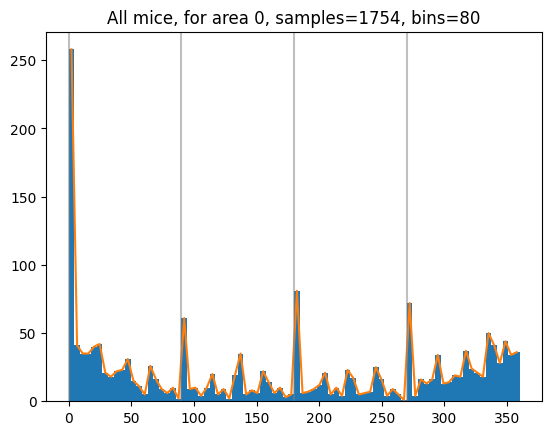

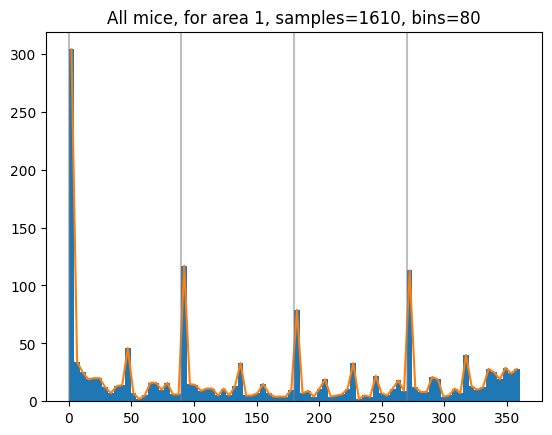

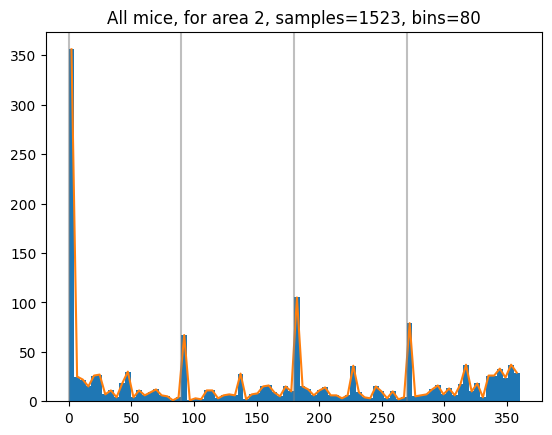

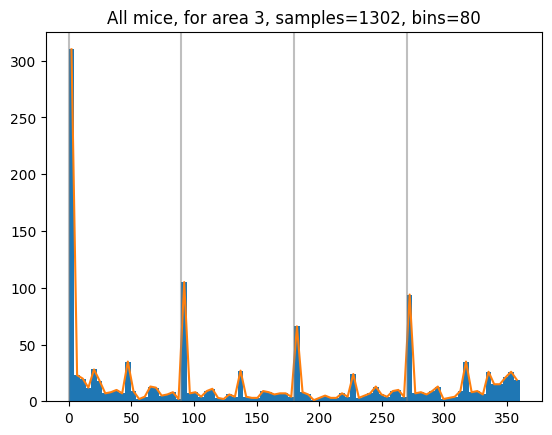

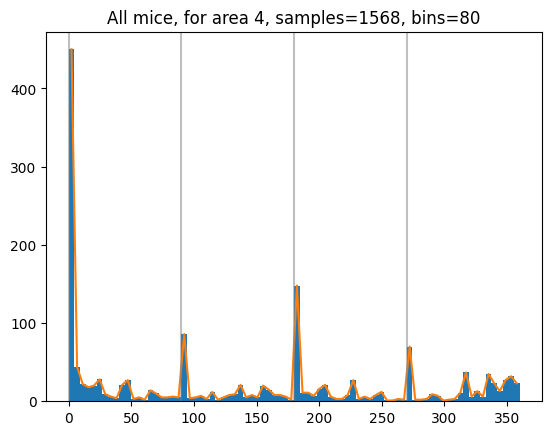

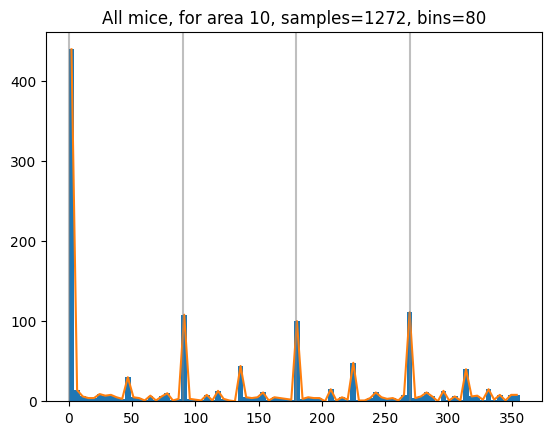

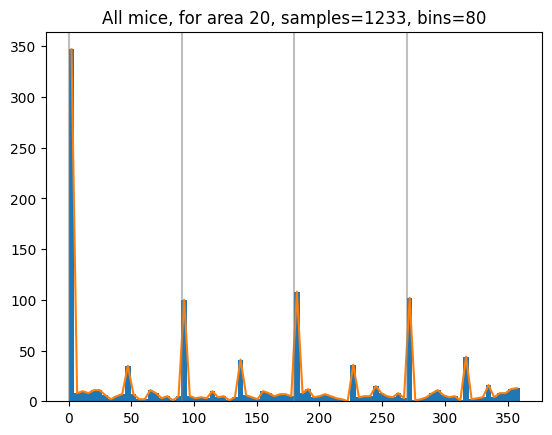

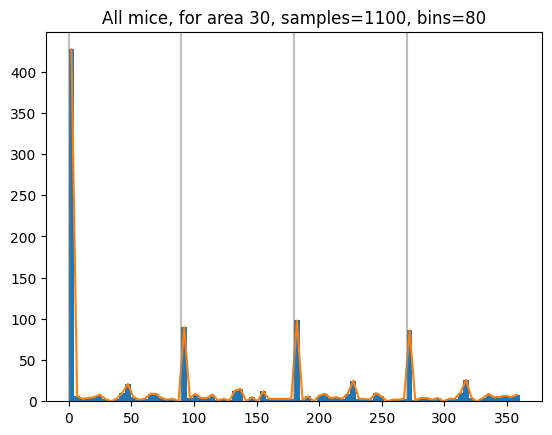

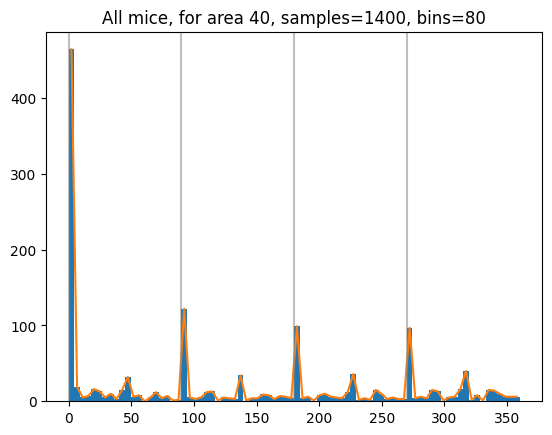

In [83]:
delta_ang_hist = {}
bins = 80

for k, df in delta_angles_all_mice.items():
    freqs, binEdges, _ = plt.hist(df, bins=bins)
    bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
    delta_ang_hist[k]  = [bin_mid, freqs]

    plt.plot(bin_mid, freqs)
    for ang in [0, 90, 180, 270]:
        plt.axvline(ang, c='grey', alpha=0.5)
    plt.title(f'All mice, for area {k}, samples={len(df)}, bins={bins}')
    plt.show()

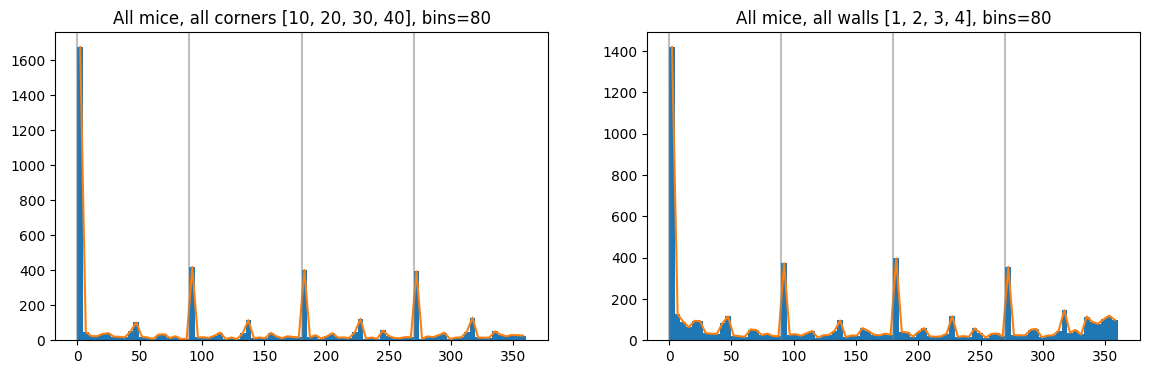

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
# All corners together
all_corn_list = [delta_angles_all_mice[k] for k in [10, 20, 30, 40]]
all_corn_df = pd.concat(all_corn_list)

freqs, binEdges, _ = axes[0].hist(all_corn_df, bins=bins)
bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
delta_ang_hist['all_corners']  = [bin_mid, freqs]

axes[0].plot(bin_mid, freqs)
axes[0].set_title(f'All mice, all corners [10, 20, 30, 40], bins={bins}')

# All walls together
all_walls_list = [delta_angles_all_mice[k] for k in [1, 2, 3, 4]]
all_walls_df = pd.concat(all_walls_list)

freqs, binEdges, _ = axes[1].hist(all_walls_df, bins=bins)
bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
delta_ang_hist['all_walls']  = [bin_mid, freqs]

axes[1].plot(bin_mid, freqs)
axes[1].set_title(f'All mice, all walls [1, 2, 3, 4], bins={bins}')
for ax_idx in [0, 1]:
    for ang in [0, 90, 180, 270]:
        axes[ax_idx].axvline(ang, c='grey', alpha=0.5)
plt.show()

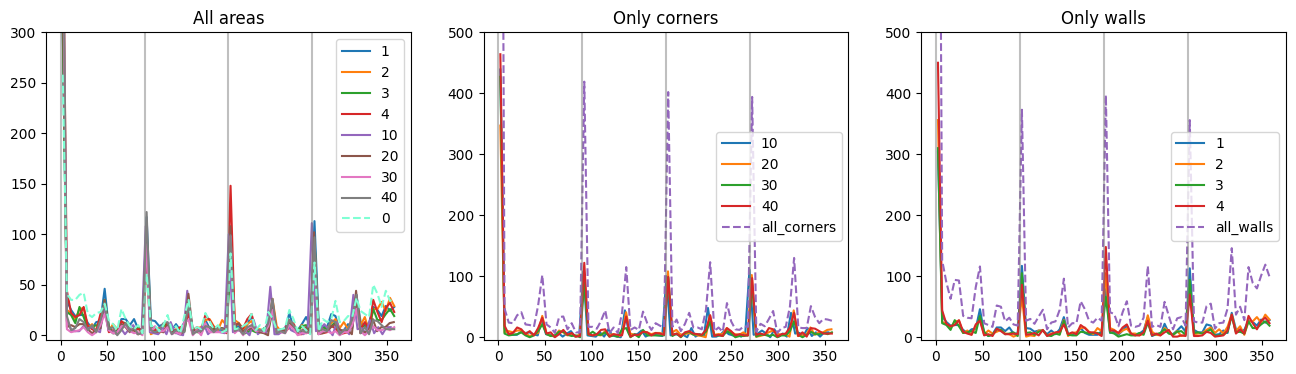

In [140]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1. All areas
for k, df in delta_ang_hist.items():
    if k not in [0, 'all_corners', 'all_walls']:
        bin_mid, freqs = df
        axes[0].plot(bin_mid, freqs, label=k)

bin_mid, freqs = delta_ang_hist[0]
axes[0].plot(bin_mid, freqs, linestyle='--', label=0, c='aquamarine')
axes[0].set_ylim([-5, 300])
axes[0].set_title('All areas')

# 2. Only corners
for k, df in delta_ang_hist.items():
    if k in [10, 20, 30, 40]:
        bin_mid, freqs = df
        axes[1].plot(bin_mid, freqs, label=k)

bin_mid, freqs = delta_ang_hist['all_corners']
axes[1].plot(bin_mid, freqs, linestyle='--', label='all_corners')
axes[1].set_title('Only corners')
axes[1].set_ylim([-5, 500])

# 3. Only walls
for k, df in delta_ang_hist.items():
    if k in [1, 2, 3, 4]:
        bin_mid, freqs = df
        axes[2].plot(bin_mid, freqs, label=k)

bin_mid, freqs = delta_ang_hist['all_walls']
axes[2].plot(bin_mid, freqs, linestyle='--', label='all_walls')
axes[2].set_title('Only walls')
axes[2].set_ylim([-5, 500])

for ax_idx in [0, 1, 2]:
    axes[ax_idx].legend()
    for ang in [0, 90, 180, 270]:
        axes[ax_idx].axvline(ang, c='grey', alpha=0.5)
plt.show()

##### надо нормализовать от 0 до 1 все эти графики

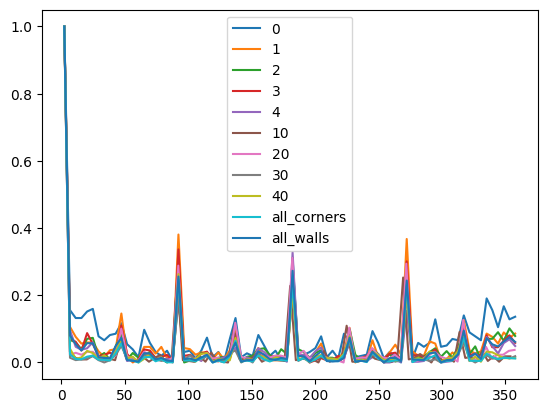

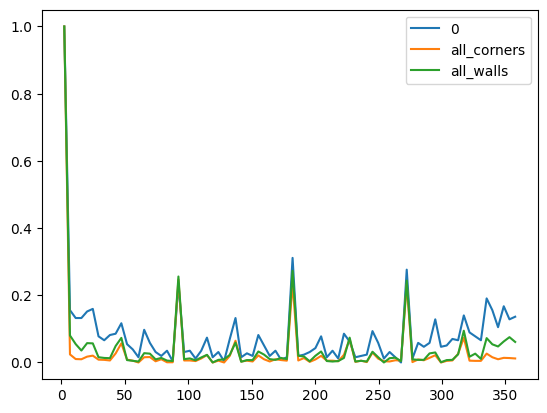

In [145]:
def min_max_normalize(y):
    yn = (y - y.min()) / (y.max() - y.min())
    return yn

for k, df in delta_ang_hist.items():
    df[1] = min_max_normalize(df[1])
    plt.plot(df[0], df[1], label=k)
plt.legend()
plt.show()

for k, df in delta_ang_hist.items():
    if k in [0, 'all_corners', 'all_walls']:
        df[1] = min_max_normalize(df[1])
        plt.plot(df[0], df[1], label=k)
plt.legend()
plt.show()

In [ ]:
### ==============================================
### STOPPED HERE
### ==============================================
### ==============================================
### ==============================================

##### можно сохранить уусредненные распределения по центру, зоне у стен и зоне углов в словарь origDistr

In [ ]:
# origDistr = {}
# for i in ['0', 'corn', 'wall']:
#     origDistr[i] = mergPlots[i]

# TODO: why??
# import pickle
# with open('angOrigDistr.pkl', 'wb') as fp:
#     pickle.dump(origDistr, fp)

#### можно сгладить распределения по гаусу

In [ ]:
# TODO: smoothing function

def smooth_angle_hist():
    pass

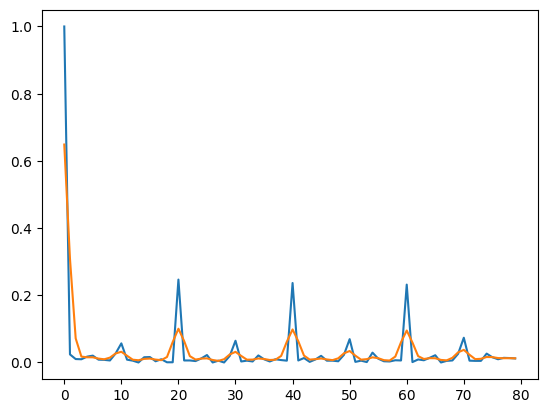

In [147]:
x = delta_ang_hist['all_corners'][1]
y3 = gaussian_filter1d(x, 1)
plt.plot(x)
plt.plot(y3)

### можно сгладить распределения с кернел денсити

from scipy.stats import norm
from sklearn.neighbors import KernelDensity

#X = mergPlots['0'][1]
X = mergDfs['0'].to_numpy()
x = mergDfs['0'].to_numpy()
X

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15192\2467016934.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  k = sns.distplot(mergDfs[i]['delta_angle'], hist=True, kde=True, bins=int(180/5), color = 'magenta',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 1})


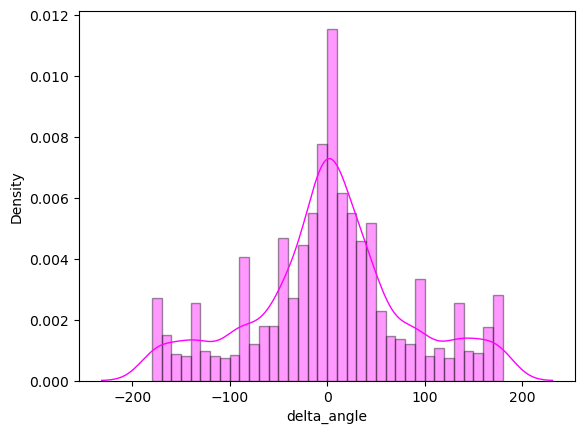

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15192\2467016934.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  k = sns.distplot(mergDfs[i]['delta_angle'], hist=True, kde=True, bins=int(180/5), color = 'magenta',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 1})


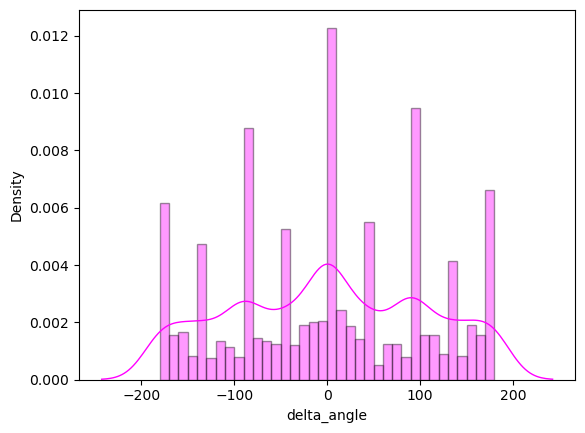

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15192\2467016934.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  k = sns.distplot(mergDfs[i]['delta_angle'], hist=True, kde=True, bins=int(180/5), color = 'magenta',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 1})


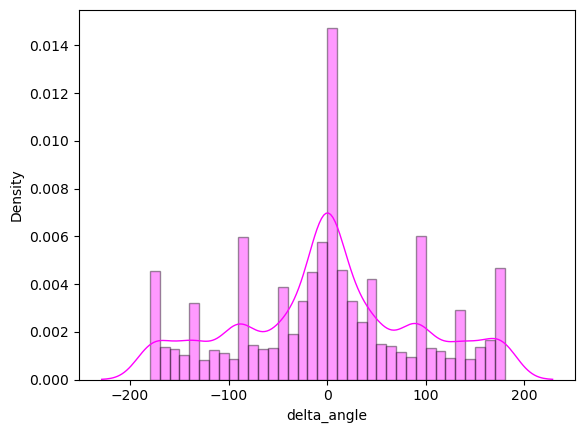

In [ ]:
finalDistr = {}
for i in ['0', 'corn', 'wall']:
    k = sns.distplot(mergDfs[i]['delta_angle'], hist=True, kde=True, bins=int(180/5),
                      color = 'magenta',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 1})
    plt.show()
    j = k.lines
    x = j[0]._xorig
    y = j[0]._yorig
    y = minMaxOfY(y)
    finalDistr[i] = [x, y]
    

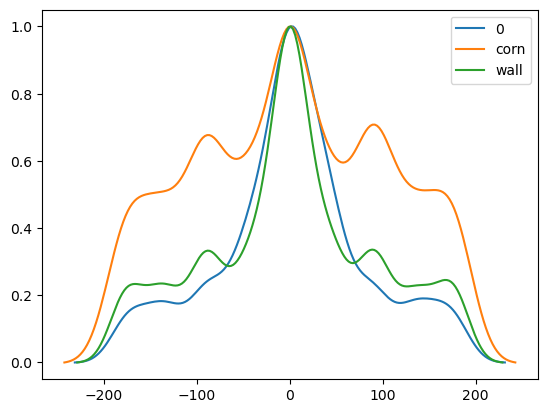

In [ ]:
for i in finalDistr:
    plt.plot(finalDistr[i][0], finalDistr[i][1], label = i)
plt.legend()

In [ ]:
import pickle
with open('angleDistr.pkl', 'wb') as fp:
    pickle.dump(finalDistr, fp)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15192\4250383979.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  k = sns.distplot(mergDfs[i]['delta_angle'], hist=True, kde=True, bins=int(180/5), color = 'magenta',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 1})


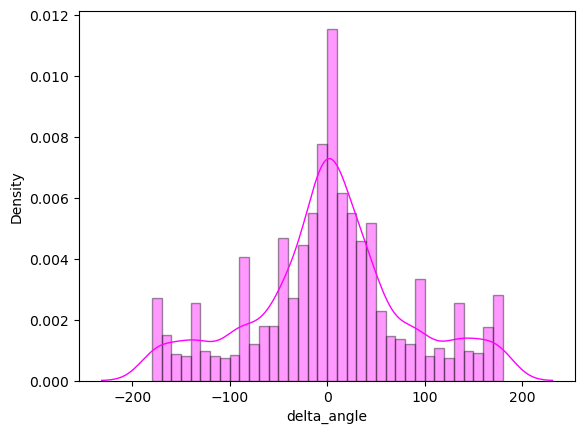

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15192\4250383979.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  k = sns.distplot(mergDfs[i]['delta_angle'], hist=True, kde=True, bins=int(180/5), color = 'magenta',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 1})


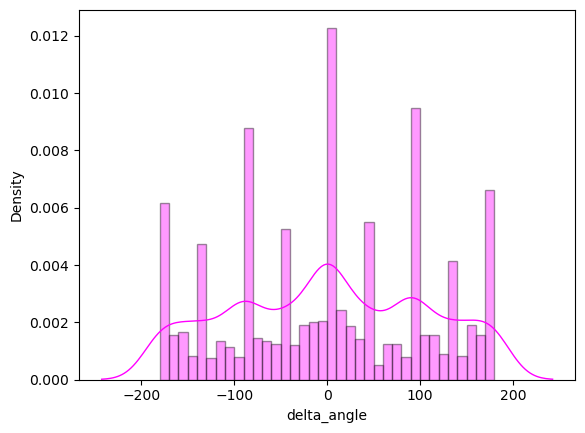

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15192\4250383979.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  k = sns.distplot(mergDfs[i]['delta_angle'], hist=True, kde=True, bins=int(180/5), color = 'magenta',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 1})


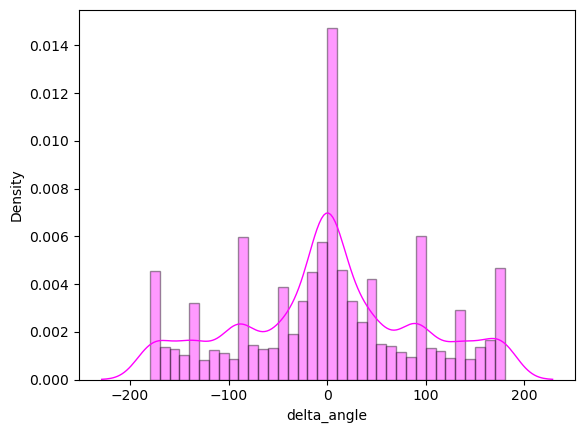

In [ ]:
finalDistr = {}
for i in ['0', 'corn', 'wall']:
    k = sns.distplot(mergDfs[i]['delta_angle'], hist=True, kde=True, bins=int(180/5), color = 'magenta',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 1})
    plt.show()
    j = k.lines
    x = j[0]._xorig
    y = j[0]._yorig
    y = minMaxOfY(y)
    finalDistr[i] = [x, y]

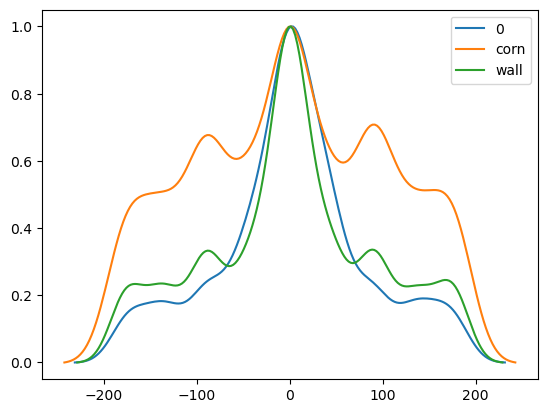

In [ ]:
for i in finalDistr:
    plt.plot(finalDistr[i][0], finalDistr[i][1], label = i)
plt.legend()